# Tobacco trial classification
In this notebook we will try to classify 13M~ documents into 10 classes. 

The data is available in two different ways :
    - Textual data 
    - Images of the documents
    

### Necessary import (Make sure you can run this before running the script )

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout, Embedding
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
def confusion_matrix_NN(NN,x_test,y_test) :
        y_pred = NN.predict(np.array(x_test))
        y_test_class = np.argmax(y_test,axis=1)
        y_pred_class = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y_pred_class,y_test_class)
        print(cf)

#### Opening metadata

In [3]:
meta_data = pd.read_csv("data/Tobacco3482.csv")

# Here I'm extracting the label
labels = np.unique(meta_data["label"])

#### Opening data

In [4]:
x = []
y = []
label_classes = {}
i = 0
for l in labels :
    path = 'data/'+l+"/*.txt"
    print("Opening "+ l +" data")
    files=glob.glob(path)   
    for file in files:
        f=open(file, 'r')  
        x.append(f.read())
        y.append(l)
        f.close()
    label_classes[i] = l
    i+=1
print("Opened "+str(len(x))+" documents, "+str(len(np.unique(y)))+" different classes" )

Opening Advertisement data
Opening Email data
Opening Form data
Opening Letter data
Opening Memo data
Opening News data
Opening Note data
Opening Report data
Opening Resume data
Opening Scientific data
Opened 3482 documents, 10 different classes


# Statistical analysis of the data

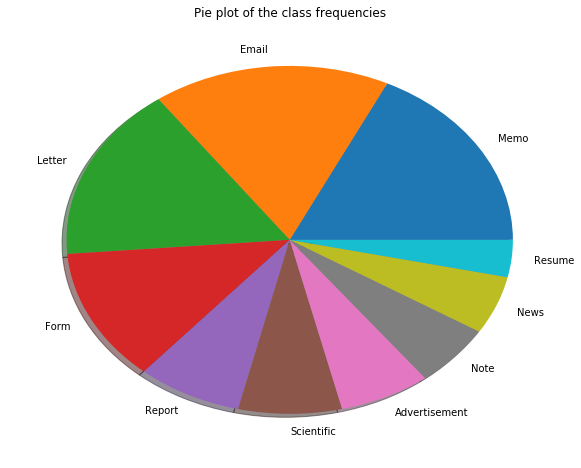

In [5]:
counts =meta_data["label"].value_counts()
plt.figure(1,figsize = (10,8))
plt.title("Pie plot of the class frequencies")
plt.pie(counts,labels = counts.index,shadow = True)
plt.savefig("Camenbert.png")
plt.show()

We can see that the classes are not very unbalanced even though 3 classes form half the data but given that they are Letter, Email and Memo, it's a normal behaviour given how the data were acquired

#### Pre-treatment of the data 

##### Tokenizing

Here we choose to tokenize the data in order to establish a baseline with a naive Bayes model.

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.1 , random_state = 42)

In [7]:
sentences = [text_to_word_sequence(s) for s in x]

vectorizer = CountVectorizer()
vectorizer.fit(x_train)

x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

In [8]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_counts,y_train)
print("Accuracy score : ")
print(clf.score(x_test_counts,y_test))
y_pred = clf.predict(x_test_counts)
print("Confusion matrix :")
print(confusion_matrix(y_test,y_pred))
print("Classification report :")
print(classification_report(y_test,y_pred))
print("Where classes are :")
for l in label_classes :
    print(str(l)+" : "+label_classes[l])

Accuracy score : 
0.673352435530086
Confusion matrix :
[[10  0  4  3  5 10  0  1  0  0]
 [ 0 56  0  3  7  0  0  0  0  0]
 [ 1  0 30  7  7  2  0  0  0  1]
 [ 0  0  0 49 11  0  0  0  0  0]
 [ 0  0  1  6 43  0  0  0  0  0]
 [ 0  0  1  0  0 14  0  0  0  0]
 [ 0  1  9  3  7  0  0  0  0  0]
 [ 0  0  0  6  3  1  0  6  0  2]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  1  2  6  3  0  0  0 18]]
Classification report :
             precision    recall  f1-score   support

          0       0.91      0.30      0.45        33
          1       0.98      0.85      0.91        66
          2       0.65      0.62      0.64        48
          3       0.62      0.82      0.71        60
          4       0.48      0.86      0.62        50
          5       0.47      0.93      0.62        15
          6       0.00      0.00      0.00        20
          7       0.86      0.33      0.48        18
          8       1.00      1.00      1.00         9
          9       0.86      0.60      0.71        30

avg /

/home/robin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Neural network part

# tokens into neural network part

In [9]:
def model_creation(dim_data): 
    # this function create a neural network model then return it
    # inputs: 
    #       dim_data : the dimension of one of the data
    dim = dim_data

    NN = Sequential()
    
    NN.add(Dense(512,activation="relu",input_shape=(dim,)))
    NN.add(Dropout(0.5))
        
    NN.add(Dense(10, activation='softmax'))

    NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN

In [10]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
callbacks=[checkpointer]
dimension_data = len(x_train_counts.toarray()[0])
NN = model_creation(dimension_data)
hist = NN.fit(x_train_counts.toarray(),to_categorical(y_train),epochs=50,validation_split=0.1,batch_size = 128,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

Train on 2819 samples, validate on 314 samples
Epoch 1/50
2819/2819 [==============================] - 7s 3ms/step - loss: 1.3695 - acc: 0.5803 - val_loss: 0.8003 - val_acc: 0.7389

Epoch 00001: val_loss improved from inf to 0.80030, saving model to weights.hdf5
Epoch 2/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.3303 - acc: 0.9319 - val_loss: 0.6661 - val_acc: 0.8121

Epoch 00002: val_loss improved from 0.80030 to 0.66608, saving model to weights.hdf5
Epoch 3/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.1339 - acc: 0.9922 - val_loss: 0.6192 - val_acc: 0.8535

Epoch 00003: val_loss improved from 0.66608 to 0.61917, saving model to weights.hdf5
Epoch 4/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.0746 - acc: 0.9947 - val_loss: 0.6292 - val_acc: 0.8185

Epoch 00004: val_loss did not improve from 0.61917
Epoch 5/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.0497 - acc: 0.9957 - val_loss: 0.

2819/2819 [==============================] - 3s 1ms/step - loss: 0.0051 - acc: 0.9982 - val_loss: 0.8231 - val_acc: 0.7675

Epoch 00043: val_loss did not improve from 0.59391
Epoch 44/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.0051 - acc: 0.9982 - val_loss: 0.8191 - val_acc: 0.7803

Epoch 00044: val_loss did not improve from 0.59391
Epoch 45/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.0050 - acc: 0.9982 - val_loss: 0.8190 - val_acc: 0.7834

Epoch 00045: val_loss did not improve from 0.59391
Epoch 46/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.0048 - acc: 0.9982 - val_loss: 0.8208 - val_acc: 0.7803

Epoch 00046: val_loss did not improve from 0.59391
Epoch 47/50
2819/2819 [==============================] - 3s 1ms/step - loss: 0.0047 - acc: 0.9982 - val_loss: 0.8182 - val_acc: 0.7866

Epoch 00047: val_loss did not improve from 0.59391
Epoch 48/50
2819/2819 [==============================] - 3s 1ms/step - loss: 

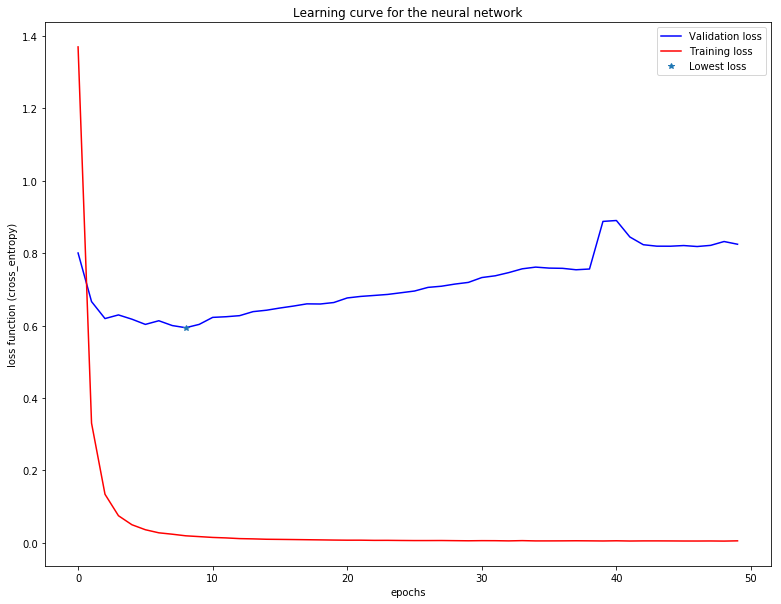

In [11]:
plt.figure("Learning curve",figsize=(13,10))
plt.plot(hist.history["val_loss"],"b")
plt.plot(hist.history["loss"],"r")
plt.plot(np.argmin(hist.history["val_loss"]),hist.history["val_loss"][np.argmin(hist.history["val_loss"])],"*")
plt.legend(("Validation loss","Training loss","Lowest loss"))
plt.title("Learning curve for the neural network")
plt.ylabel("loss function (cross_entropy)")
plt.xlabel("epochs")
plt.savefig("Graph_learning.png")
plt.show()

In [12]:
print("Accuracy score :")
print(NN.evaluate(x_test_counts.toarray(),to_categorical(y_test))[1])

print("Confusion matrix :")
confusion_matrix_NN(NN,x_test_counts.toarray(),to_categorical(y_test))

print("Classification report :")
y_pred = NN.predict(np.array(x_test_counts.toarray()))
y_test_class = np.argmax(to_categorical(y_test),axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))

print("Where classes are :")
for l in label_classes :
    print(str(l)+" : "+label_classes[l])

Accuracy score :
349/349 [==============================] - 0s 585us/step
0.8481375380368492
Confusion matrix :
[[21  0  1  0  0  0  1  0  0  0]
 [ 0 66  0  1  1  0  0  0  0  0]
 [ 0  0 39  2  0  1  0  1  0  1]
 [ 0  0  2 49  1  0  0  3  0  0]
 [ 0  0  1  4 45  0  0  0  0  0]
 [ 2  0  0  0  0 13  0  0  0  2]
 [ 9  0  4  1  2  1 19  0  0  2]
 [ 1  0  1  3  0  0  0 12  0  2]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  1  0  0  2  0 23]]
Classification report :
             precision    recall  f1-score   support

          0       0.91      0.64      0.75        33
          1       0.97      1.00      0.99        66
          2       0.89      0.81      0.85        48
          3       0.89      0.82      0.85        60
          4       0.90      0.90      0.90        50
          5       0.76      0.87      0.81        15
          6       0.50      0.95      0.66        20
          7       0.63      0.67      0.65        18
          8       1.00      1.00      1.00         9
  

# Conclusion and comparaison 

In the previous part, we compared two approaches for the resolution of this problem. We established a baseline which was training a naive bayes model on the tfidf transformed data. The second approach was to use a recurrent neural network to classify the same data. 
As we could observe, the bayesian model established a baseline at ~70% accuracy. We succedeed in reaching a 85% accuracy in test with the neural network. 
Concerning the confusion matrix of the 2 models, the bayesian one is really unbalanced since many classes are mistaken for memo. This might be caused by the over representation of the memo class. 
However we can see that the confusion matrix of the neural network is balanced.